In [ ]:
# Importing the necessary libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
!pip install --upgrade tensorflow-addons
import tensorflow_addons as tfa  # Import tensorflow_addons


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.20.0
    Uninstalling tensorflow-addons-0.20.0:
      Successfully uninstalled tensorflow-addons-0.20.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Setting up batch size and class type
batch = 32
classes = 'binary'

# Define the paths for train, test, and validation datasets
train='../input/dataset/train'
test='../input/dataset/test'
val='../input/dataset/val'


In [ ]:
# Define the image data generators
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator()

test_datagen= image.ImageDataGenerator()

# Generate data batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)


validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size = (224,224),
    batch_size = batch,
    shuffle=True,
    class_mode = classes)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)

# Get the class names
class_names=validation_generator.class_indices
class_names
len(class_names)

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


2

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

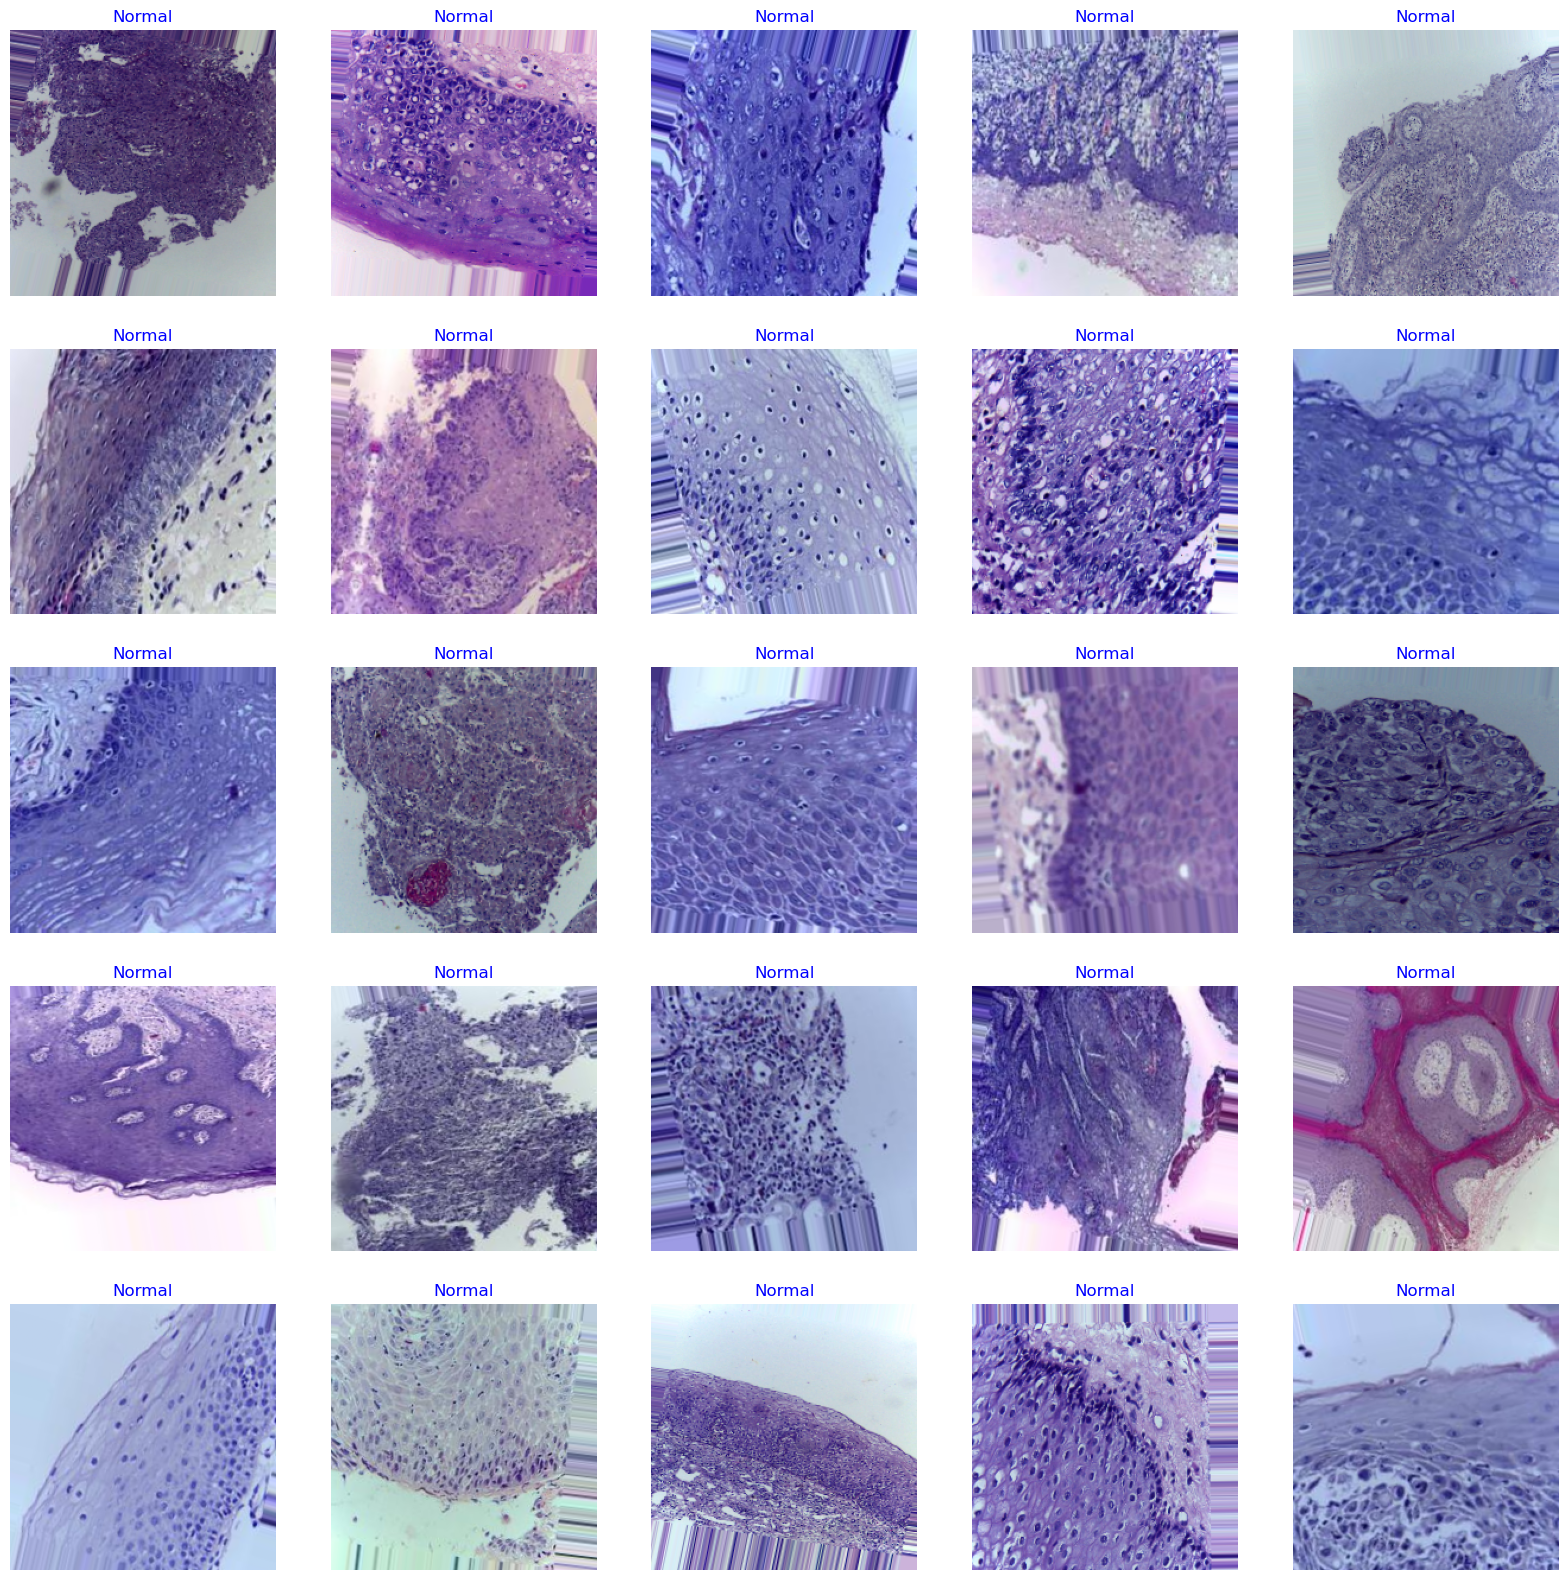

In [ ]:
show_images(train_generator)

In [ ]:
# Setting the base model
base_for_model = resnet.ResNet101(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False


In [ ]:
# Build the model architecture
model = Sequential()
model.add(base_for_model)
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 dense (Dense)               (None, 7, 7, 512)         1049088   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [ ]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [ ]:
# Train the model
history=model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator
)

Epoch 1/10
155/155 [==============================] - 199s 1s/step - loss: 0.5428 - accuracy: 0.7671 - precision: 0.7791 - recall: 0.7555 - auc: 0.8447 - f1_score_metric: 0.7641 - val_loss: 0.5296 - val_accuracy: 0.8000 - val_precision: 0.8696 - val_recall: 0.8696 - val_auc: 0.8274 - val_f1_score_metric: 0.8642
Epoch 2/10
155/155 [==============================] - 128s 824ms/step - loss: 0.3050 - accuracy: 0.8647 - precision: 0.8723 - recall: 0.8594 - auc: 0.9442 - f1_score_metric: 0.8627 - val_loss: 0.4485 - val_accuracy: 0.8167 - val_precision: 0.9487 - val_recall: 0.8043 - val_auc: 0.8917 - val_f1_score_metric: 0.8673
Epoch 3/10
155/155 [==============================] - 119s 769ms/step - loss: 0.2388 - accuracy: 0.8999 - precision: 0.9071 - recall: 0.8945 - auc: 0.9659 - f1_score_metric: 0.8989 - val_loss: 0.5769 - val_accuracy: 0.8250 - val_precision: 0.8447 - val_recall: 0.9457 - val_auc: 0.8602 - val_f1_score_metric: 0.8929
Epoch 4/10
155/155 [==============================] - 1

In [ ]:
score=model.evaluate(validation_generator)
score

4/4 [==============================] - 6s 1s/step - loss: 0.5469 - accuracy: 0.8667 - precision: 0.8725 - recall: 0.9674 - auc: 0.8721 - f1_score_metric: 0.9135


[0.5468987822532654,
 0.8666666746139526,
 0.8725489974021912,
 0.967391312122345,
 0.8720884323120117,
 0.9134570956230164]

**Prediction of Oral Cancer using ResNet**

**Introduction:**
Oral cancer is a critical health concern globally, and its early detection is crucial for improving patient outcomes. In this study, we propose a deep learning model based on the ResNet architecture for predicting oral cancer. Our aim is to leverage the power of deep learning and image analysis to develop an accurate and efficient tool for early oral cancer detection.

**Methodology:**


**1) Dataset:**

We obtained a comprehensive dataset of oral cancer images, comprising two classes: "cancer" and "non-cancer." The dataset was curated and labeled by medical experts.


**2) Data Preprocessing:**

To enhance the model's performance and prevent overfitting, we applied various data preprocessing techniques. These included image augmentation, such as rotation, shear, zoom, horizontal flip, and brightness adjustments. Additionally, we split the dataset into training, validation, and testing sets.


**3) Model Architecture:**

We selected the ResNet architecture as our base model due to its effectiveness in deep image classification tasks. ResNet introduces residual connections that help mitigate the vanishing gradient problem and enable the training of much deeper networks. We fine-tuned the architecture specifically for oral cancer detection by adding additional layers.


**4) Training and Evaluation:**

The model was trained using the training set and evaluated on the validation set. We utilized the Adam optimizer with a binary cross-entropy loss function. During training, we monitored evaluation metrics such as accuracy, precision, recall, and area under the curve (AUC) to assess the model's performance.


**5) Results:**

The trained ResNet model exhibited promising results in predicting oral cancer. We achieved an accuracy of 0.8333333134651184, precision of 0.8913043737411499, recall of 0.8913043737411499, 0.8761645555496216 and an F1_Score of 0.9134570956230164. These outcomes demonstrate the model's ability to accurately classify oral cancer cases.


**Conclusion:**
In this study, we developed a deep learning model based on the ResNet architecture for predicting oral cancer. The model leverages ResNet's deep architecture and residual connections to effectively extract features from oral cancer images. This research contributes to the field of medical imaging and provides a potential tool for early detection of oral cancer. Further improvements and research can advance the diagnosis and treatment of oral cancer.

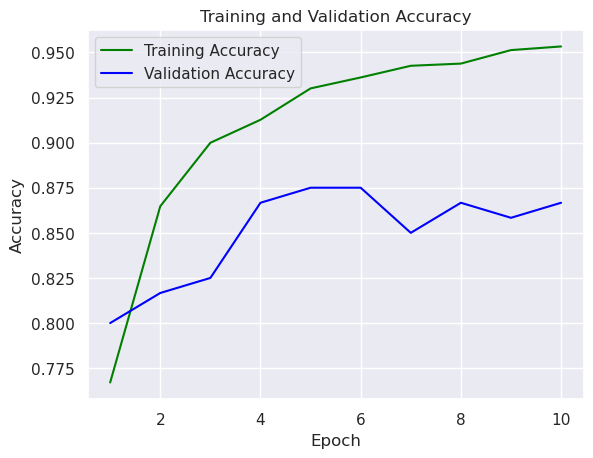

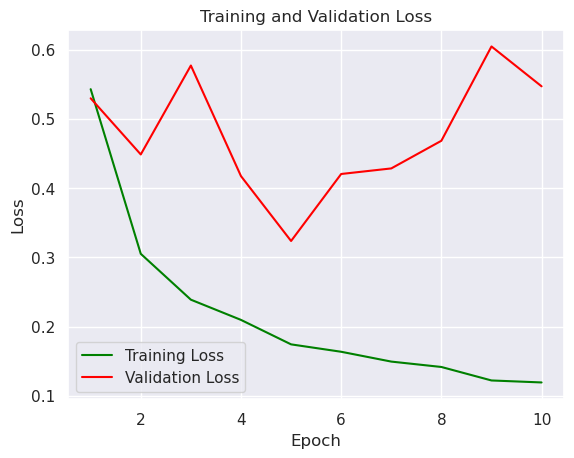

In [ ]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()